In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The **Titanic disaster** is one of the most well-known shipwrecks in history.  

On April 15, 1912, during its first trip, the "unsinkable" Titanic hit an iceberg and sank. There were 2,224 people on board, but only 722 survived because there were not enough lifeboats.  

While luck played a role in survival, some groups had a higher chance of living than others. Factors like age, gender, ticket class, and fare price affected survival rates. Women and children had better chances, while passengers in lower classes faced more danger.

By studying the Titanic data, I found these patterns and built a model to predict who was more likely to survive.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
df=pd.read_csv("/content/drive/MyDrive/TCS/Titanic-Dataset.csv")


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.shape

(891, 12)

In [6]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
df.Cabin.value_counts()

,count
Cabin,
B96 B98,4
G6,4
C23 C25 C27,4
C22 C26,3
F33,3
...,...
E34,1
C7,1
C54,1


In [8]:
df['Age'].skew()

0.38910778230082704

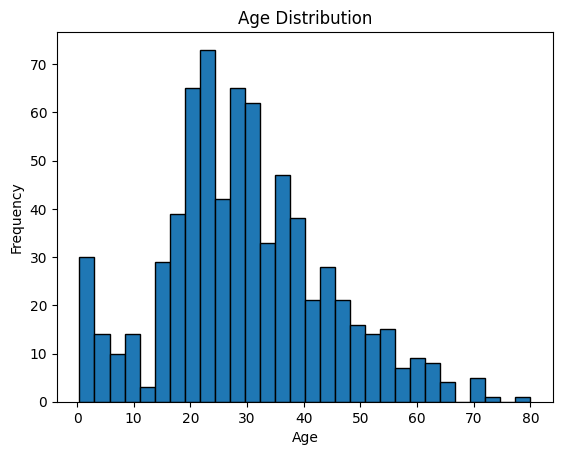

In [9]:
plt.hist(df['Age'].dropna(),bins=30,edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

## **1. Handling Missing Values**

In [10]:
# As we can see in the histogram, most passengers are between 20-40 years old.
# Using the median to fill missing values is best because it is not affected by extreme values and keeps the data realistic.
# If we use the mean, the data may be skewed by outliers, making it less accurate.

df['Age']=df['Age'].fillna(df['Age'].median())

In [11]:
# Since only two values are missing, filling them with the most common value keeps the data accurate and consistent.

df['Embarked']=df['Embarked'].fillna(df['Embarked'].mode()[0])

In [12]:
# The 'Cabin' column has 687 missing values (77% of data).
# Since too much data is missing, it's best to drop the column.

df.drop(columns=['Cabin'],inplace=True)

In [13]:
df.columns.tolist()

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']

In [14]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


# **2. Relationship between Ticket classes and Passenger Survival.**

In [15]:
# Count of passengers in each class

df['Pclass'].value_counts()

,count
Pclass,
3,491
1,216
2,184


In [16]:
# Count of survivors and non-survivors in each class

pd.crosstab(df['Pclass'],df['Survived'])

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [17]:
# Survival rate by class

df.groupby('Pclass')['Survived'].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


**Visual representations can provide clearer insights into the data.**

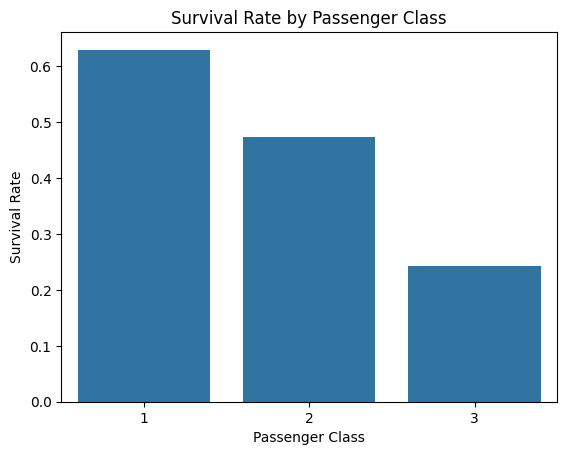

In [18]:
# Bar plot of survival rate by class

sns.barplot(x='Pclass', y='Survived',data=df,errorbar=None)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

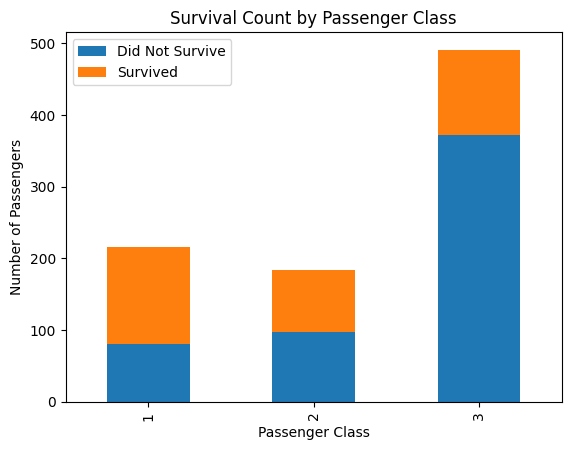

In [19]:
# Crosstab of Pclass and Survived
pclass_survived = pd.crosstab(df['Pclass'], df['Survived'])

# Stacked bar chart
pclass_survived.plot(kind='bar', stacked=True)
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Number of Passengers')
plt.legend(['Did Not Survive', 'Survived'])
plt.show()


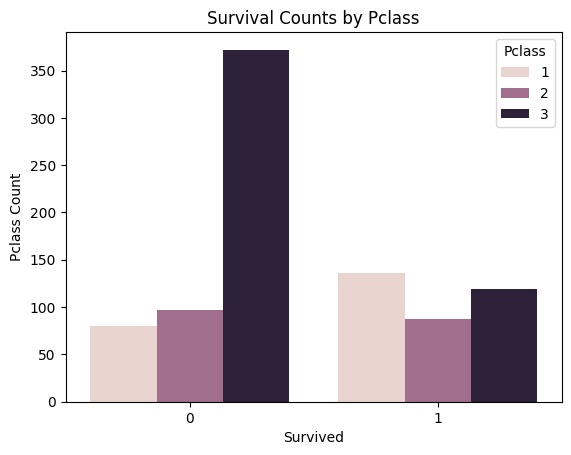

In [20]:
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.title('Survival Counts by Pclass')
plt.xlabel('Survived')
plt.ylabel('Pclass Count')
plt.show()

## Conclusion: Relationship Between Ticket Class and Survival  

- **1st class:** 62.9% survived (136 out of 216).  
- **2nd class:** 47.3% survived (87 out of 184).  
- **3rd class:** 24.2% survived (119 out of 491).  
- More 3rd class passengers did not survive compared to other classes.  

- With this analysis, we can see that Higher-class passengers had a better chance of survival.  



# **3. Identifying outliers, if any, for all features.**




In [21]:
df.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [22]:
numerical_cols=df.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_cols=df.select_dtypes(include=["object","category"]).columns.tolist()

print("Numerical columns",numerical_cols)
print("Categorical columns",categorical_cols)

Numerical columns ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns ['Name', 'Sex', 'Ticket', 'Embarked']


In [23]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


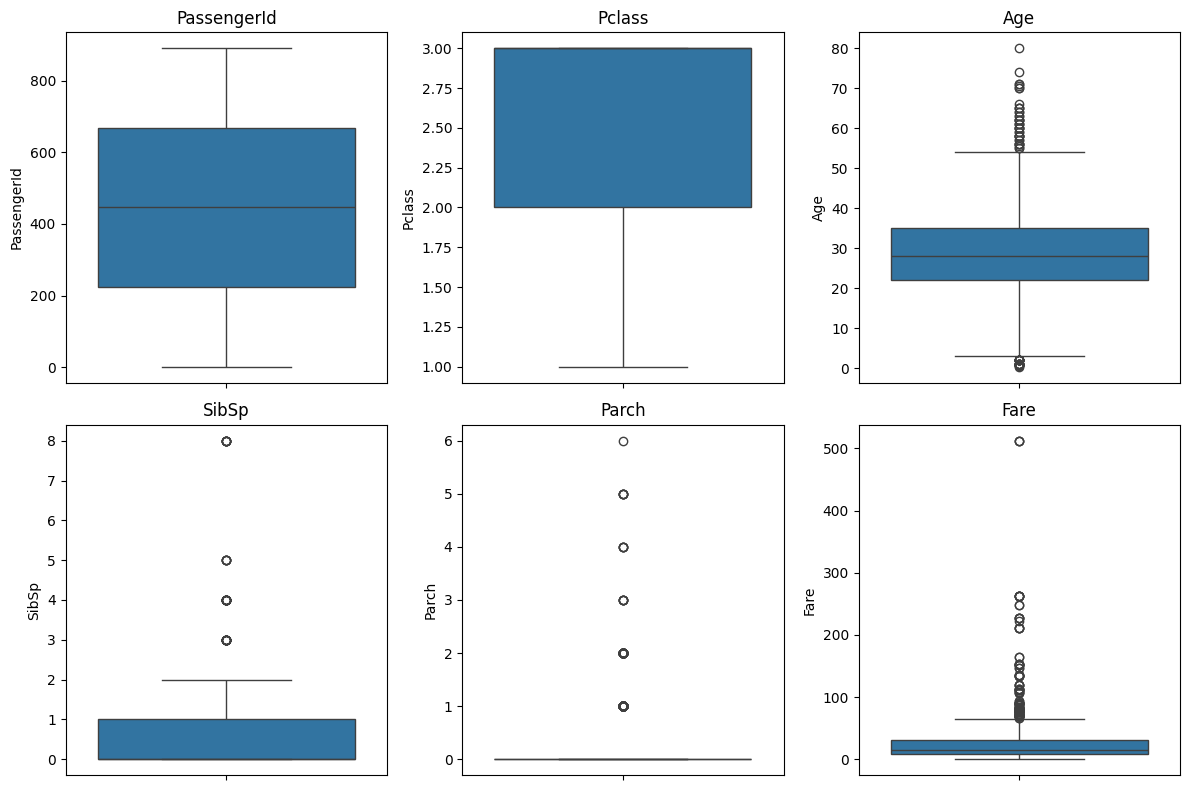

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Numerical columns
numerical_columns = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Plot boxplots for each numerical column
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


# Outliers Analysis from Boxplots

## 1. PassengerId
- No outliers.
- It is just a number given to each passenger.

## 2. Pclass
- No outliers.
- It has only 3 values (1, 2, and 3), which are normal.

## 3. Age
- Some outliers.
- A few passengers are older than 60 years.

## 4. SibSp (Siblings/Spouses Aboard)
- Some outliers.
- A few passengers have more than 3 siblings or spouses.

## 5. Parch (Parents/Children Aboard)
- Some outliers.
- A few passengers have more than 3 parents or children with them.

## 6. Fare
- Many outliers.
- Some passengers paid very high prices (above 100), likely for first-class cabins.

### Conclusion
- **Age, SibSp, Parch, and Fare have outliers.**
- These outliers show some passengers had big families, were old, or paid high ticket prices.



---



**Capping to Handle Outliers**

Outliers are extreme values that can affect data analysis and model performance. Instead of removing them, we can use **capping**, which means setting a maximum limit for high values. This helps in:

- **Keeping useful data** instead of deleting important records.
- **Reducing the effect of extreme values** without losing information.
- **Maintaining the dataset size** for better model training.
- **Avoiding bias** that may happen if we remove too many records.

For example, if the age in a dataset has extreme values like 80 or 90, we can cap it at 60 so that all values above 60 are set to 60. This way, we handle outliers without losing data.


In [25]:
#Handling Outlier for Age Column
df['Age']=df['Age'].apply(lambda x:min(x,60)) # Cap age at 60

In [26]:
#Handling Outlier for SibSp Column
df['SibSp'] = df['SibSp'].apply(lambda x: min(x, 3))  # Cap SibSp at 3


In [27]:
#Handling Outlier for Parch Column
df['Parch'] = df['Parch'].apply(lambda x: min(x, 3))  # Cap Parch at 3


In [28]:
# Log Transformation
# Here, there are extreme outliers, so log transformation is useful to reduce their impact.
# It compresses large values and makes the data more balanced. This helps in better analysis and improves model performance.

df['Fare'] = np.log1p(df['Fare'])  # log1p is used to avoid log(0) issues


In [29]:
df.shape

(891, 11)

In [30]:
# Count records that are capped at the max threshold
age_capped = (df['Age'] ==60).sum()
fare_capped = (df['Fare'] == 100).sum()
sibsp_capped = (df['SibSp'] == 2).sum()
parch_capped = (df['Parch'] == 3).sum()

print(f"Number of records where Age = 60: {age_capped}")
print(f"Number of records where Fare = 100: {fare_capped}")
print(f"Number of records where SibSp = 2: {sibsp_capped}")
print(f"Number of records where Parch = 3: {parch_capped}")


Number of records where Age = 60: 26
Number of records where Fare = 100: 0
Number of records where SibSp = 2: 28
Number of records where Parch = 3: 15


### Why I prefered Capping here?  
I felt Capping is better than removing outliers because it keeps useful data while limiting extreme values. Removing outliers may cause data loss, but capping ensures that the dataset remains balanced and still useful for analysis.  

For example, in our dataset:  
- **26 records** have Age capped at value **60**  
- **28 records** have SibSp capped at value  **2**  
- **15 records** have Parch capped at value  **3**  

Since many records which could be useful for analysis would be removed if we deleted outliers, capping helps us keep important information while reducing the impact of extreme values.

Removing outliers is only better if the outliers are due to errors or are extremely different from the rest of the data. Since the counts are not too large, capping is the best choice here.




---





## **#  4. Correlation plot for the numeric features in the dataset.**

In [31]:
numerical_df=df.select_dtypes(include=['number'])

correlation_matrix= numerical_df.corr()

print(correlation_matrix)

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.034194 -0.074953 -0.003953   
Survived       -0.005007  1.000000 -0.338481 -0.063227  0.012638  0.106532   
Pclass         -0.035144 -0.338481  1.000000 -0.341668  0.041981  0.002457   
Age             0.034194 -0.063227 -0.341668  1.000000 -0.259869 -0.222922   
SibSp          -0.074953  0.012638  0.041981 -0.259869  1.000000  0.459986   
Parch          -0.003953  0.106532  0.002457 -0.222922  0.459986  1.000000   
Fare           -0.007425  0.329862 -0.661022  0.111542  0.352756  0.355123   

                 Fare  
PassengerId -0.007425  
Survived     0.329862  
Pclass      -0.661022  
Age          0.111542  
SibSp        0.352756  
Parch        0.355123  
Fare         1.000000  


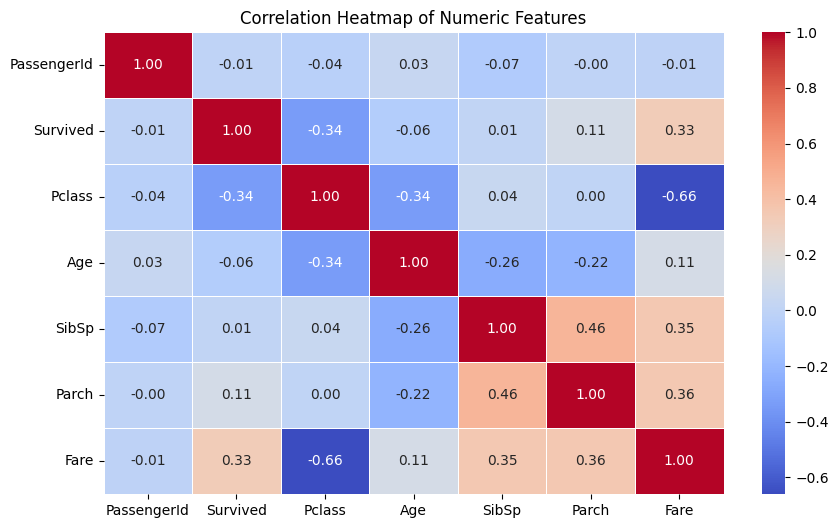

In [32]:
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**## Insights from Correlation Heatmap**

- **Pclass & Fare (-0.66):** Higher-class passengers (lower Pclass value) paid higher fares.
- **Pclass & Survived (-0.34):** Higher-class passengers had a better survival rate.
- **Fare & Survived (0.33):** Passengers who paid higher fares had a higher chance of survival.
- **SibSp & Parch (0.46):** People with siblings/spouses also had parents/children onboard.
- **Age & Pclass (-0.34):** Older passengers were more likely in higher classes.
- **Parch & Fare (0.36):** Families generally paid more in fares.
- **SibSp & Fare (0.35):** People traveling with family members had higher fares.

### Key Takeaways:
- Class and fare strongly influenced survival.
- Family size played a role in ticket pricing.
- Older passengers were often in higher classes.



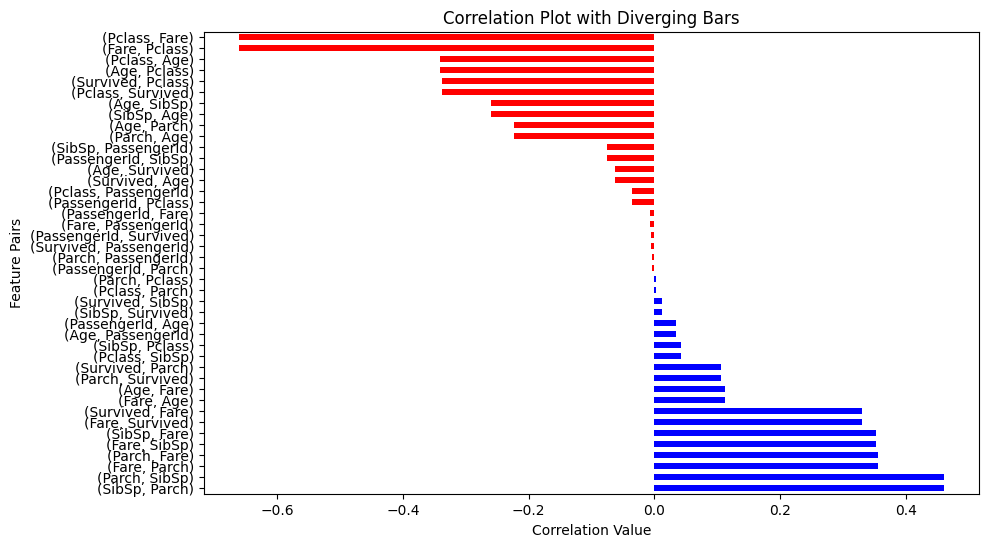

In [33]:
# Plot the correlation matrix with diverging bars
fig, ax = plt.subplots(figsize=(10, 6))
pos_corr = correlation_matrix.unstack().sort_values(ascending=False)
pos_corr = pos_corr[pos_corr < 1]  # Remove diagonal (self-correlation)

# Create diverging bar plot
colors = ["red" if x < 0 else "blue" for x in pos_corr]
pos_corr.plot(kind='barh', color=colors, ax=ax)
plt.title("Correlation Plot with Diverging Bars")
plt.xlabel("Correlation Value")
plt.ylabel("Feature Pairs")
plt.show()



---



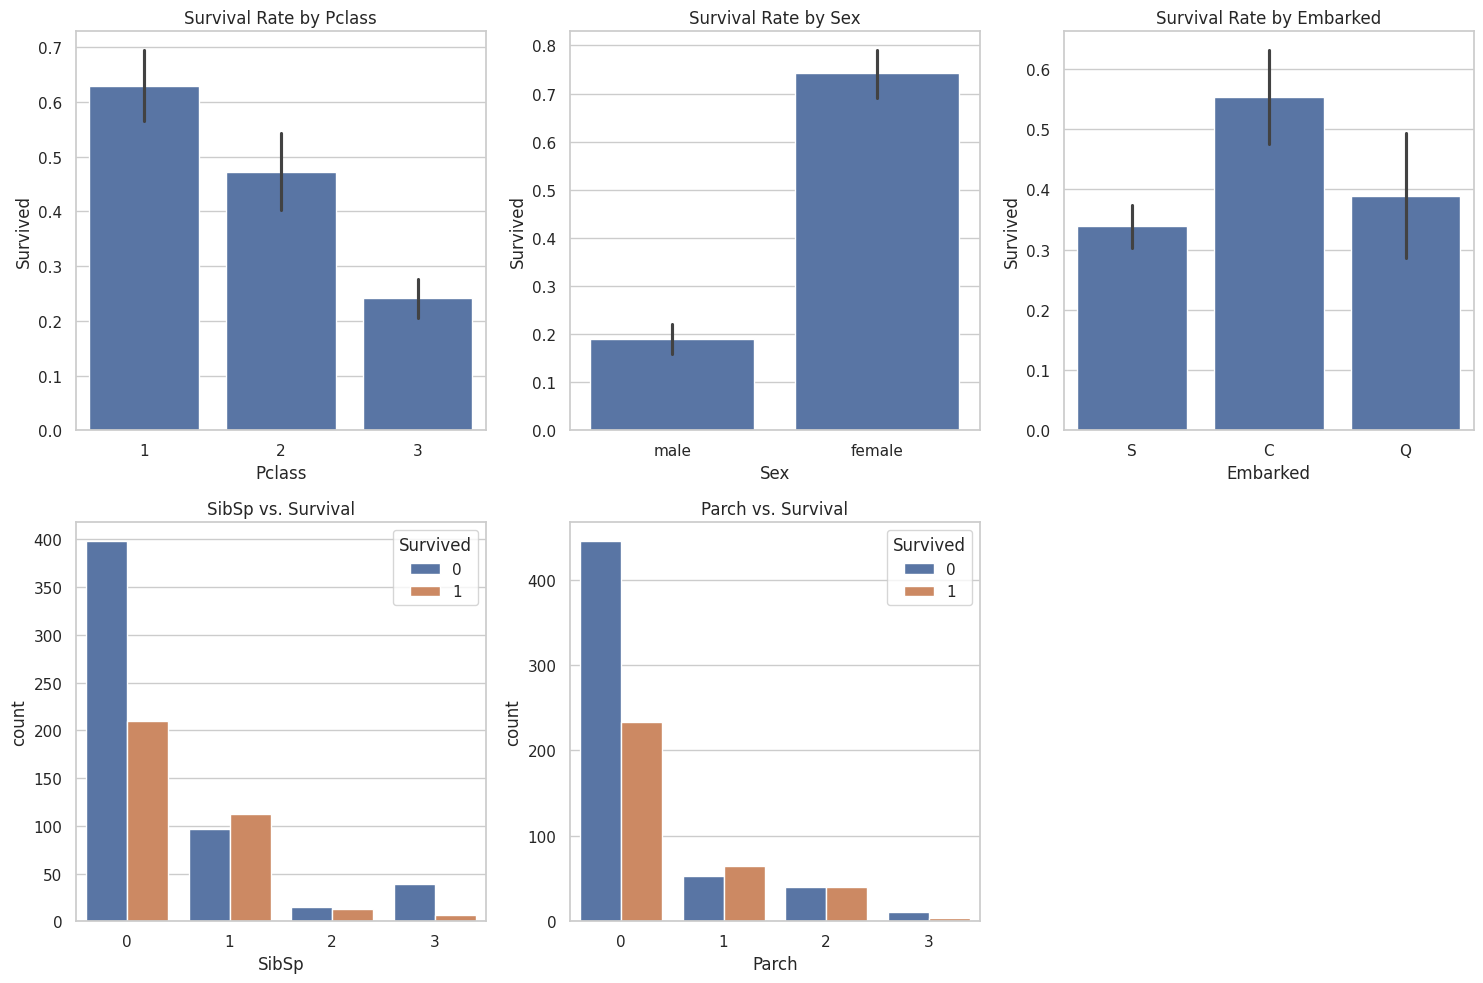

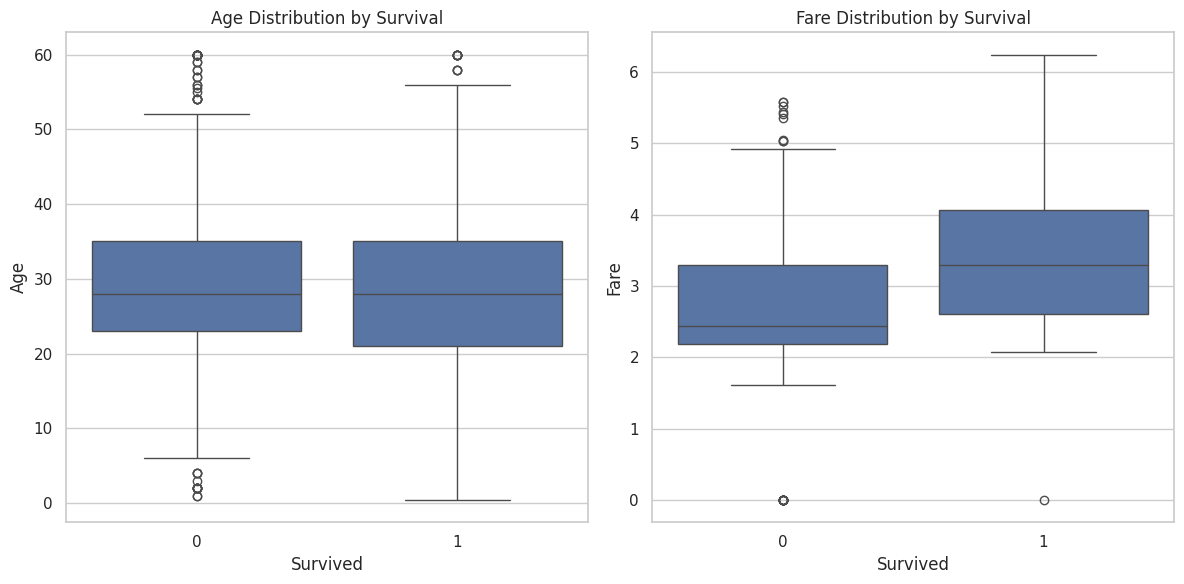

In [34]:
# Set style
sns.set(style="whitegrid")

# Categorical Features Analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title("Survival Rate by Pclass")

plt.subplot(2, 3, 2)
sns.barplot(x='Sex', y='Survived', data=df)
plt.title("Survival Rate by Sex")

plt.subplot(2, 3, 3)
sns.barplot(x='Embarked', y='Survived', data=df)
plt.title("Survival Rate by Embarked")

plt.subplot(2, 3, 4)
sns.countplot(x='SibSp', hue='Survived', data=df)
plt.title("SibSp vs. Survival")

plt.subplot(2, 3, 5)
sns.countplot(x='Parch', hue='Survived', data=df)
plt.title("Parch vs. Survival")

plt.tight_layout()
plt.show()

# Numerical Features Analysis
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Survived', y='Age', data=df)
plt.title("Age Distribution by Survival")

plt.subplot(1, 2, 2)
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title("Fare Distribution by Survival")

plt.tight_layout()
plt.show()



### Insights from the Visualizations:

1. **Pclass vs. Survival:**  
   - Higher-class passengers (Pclass 1) had a better survival rate than lower-class passengers (Pclass 3).  
   - Pclass 3 had the lowest survival rate.

2. **Sex vs. Survival:**  
   - Females had a much higher survival rate than males.  
   - This suggests that women were prioritized for rescue.

3. **Embarked vs. Survival:**  
   - Passengers who embarked from 'C' had the highest survival rate, while those from 'S' had the lowest.

4. **SibSp vs. Survival:**  
   - Passengers traveling alone (SibSp = 0) had a lower survival rate than those with one or two siblings/spouses.  
   - Having too many family members (SibSp > 2) reduced survival chances.

5. **Parch vs. Survival:**  
   - Passengers with 1–2 parents/children had better survival rates than those alone.  
   - Large families (Parch > 2) had a lower survival rate.

6. **Age Distribution by Survival:**  
   - Median age of survivors and non-survivors is similar, but older passengers had more variation.  
   - Some very young children had a better survival chance.

7. **Fare Distribution by Survival:**  
   - Passengers who paid higher fares had better survival chances.  
   - This aligns with higher-class passengers having better survival rates.

In [35]:
# Drop Unwanted Columns
df=df.drop(columns=['PassengerId', 'Name', 'Ticket'])

In [36]:
# Define Features and Target
X = df.drop(columns=['Survived'])
y = df['Survived']

In [37]:
cat_features = ['Sex', 'Embarked']
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [40]:
# Preprocessing
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [49]:
# categorical_columns = ['Sex', 'Embarked', 'Pclass']
# df = pd.get_dummies(df, columns=categorical_columns)

In [42]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,2.110213,S
1,1,1,female,38.0,1,0,4.280593,C
2,1,3,female,26.0,0,0,2.188856,S
3,1,1,female,35.0,1,0,3.990834,S
4,0,3,male,35.0,0,0,2.202765,S


In [60]:

# Define Model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])



# **5**. **Identify metrics that you will measure to understand the performance of your code.**

# Identifying Performance Metrics

- **Accuracy**: Measures how many predictions were correct out of all predictions.
- **ROC AUC Score**: Shows how well the model separates the two classes.
- **Precision**: Tells how many predicted positives are actually correct.
- **Recall**: Shows how many actual positives were correctly identified.
- **F1-Score**: Balances precision and recall for overall performance.
- **Confusion Matrix**: Displays the number of correct and incorrect predictions for each class.

These metrics help us understand if our model is good and where it needs improvement.

# **6. Instrument your code to measure your identified metrics.**

In [61]:

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

# Print Results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('Classification Report:\n', report)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.8156
ROC AUC Score: 0.8920
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179

Confusion Matrix:
 [[91 14]
 [19 55]]


In [46]:
# Hyperparameter Tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_:.4f}')


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best Accuracy: 0.8258


In [68]:
# Train Model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)


# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('Classification Report:\n', report)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.8156
ROC AUC Score: 0.8920
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179

Confusion Matrix:
 [[91 14]
 [19 55]]


# Model Performance Analysis

## Initial Model Performance
- **Accuracy:** 81.56% → The model performs well but can be improved.
- **ROC AUC Score:** 0.8920 → Good ability to distinguish between classes.
- **Precision & Recall:**
  - **Class 0 (Not Survived):** Precision = 0.83, Recall = 0.87 → Most non-survivors are correctly classified.
  - **Class 1 (Survived):** Precision = 0.80, Recall = 0.74 → Some survivors are misclassified.
- **Misclassifications:** 19 survivors were wrongly predicted as non-survivors.
- **Confusion Matrix:**
[[91 14] [19 55]]

In [63]:
# Updated Hyperparameter Grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],  # More trees
    'classifier__max_depth': [None, 10, 20, 30],  # Higher depth
    'classifier__min_samples_split': [2, 5, 10, 15],  # More control over splits
    'classifier__min_samples_leaf': [1, 2, 5, 10],  # Adjusting leaf nodes
    'classifier__bootstrap': [True, False]  # Trying both bootstrap options
}

# Run GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [64]:

grid_search.fit(X_train, y_train)

# Print Best Parameters and Best Score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_:.4f}')




Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 300}
Best Accuracy: 0.8272


In [66]:
# Extract best parameters and remove "classifier__" prefix
best_params_cleaned = {key.split("__")[1]: value for key, value in best_params.items()}

# Train final model with cleaned parameters
final_model = RandomForestClassifier(**best_params_cleaned, random_state=42)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

final_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_final = final_pipeline.predict(X_test)

# Evaluate performance
final_accuracy = accuracy_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, final_pipeline.predict_proba(X_test)[:, 1])
final_report = classification_report(y_test, y_pred_final)
final_conf_matrix = confusion_matrix(y_test, y_pred_final)

# Print final results
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(f'Final ROC AUC Score: {final_roc_auc:.4f}')
print('Final Classification Report:\n', final_report)
print('Final Confusion Matrix:\n', final_conf_matrix)


Final Test Accuracy: 0.8380
Final ROC AUC Score: 0.8981
Final Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87       105
           1       0.85      0.74      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

Final Confusion Matrix:
 [[95 10]
 [19 55]]





---


## Performance After Optimization
- **Final Accuracy:** 83.80% → Improved model accuracy.
- **Final ROC AUC Score:** 0.8981 → Slightly better class separation.
- **Precision & Recall:**
  - **Class 0 (Not Survived):** Precision = 0.83, Recall = 0.90 → Better identification of non-survivors.
  - **Class 1 (Survived):** Precision = 0.85, Recall = 0.74 → Small improvement in precision but recall remains the same.
- **Misclassifications:** Reduced from 14 to 10 for Class 0.
- **Confusion Matrix:**
[[95 10] [19 55]]

**Performance Improvement Summary:**

- Accuracy increased from **81.56% to 83.80%**.
- Better distinction between classes with a higher **ROC AUC Score (0.8981)**.
- Improved recall for **Class 0**, meaning fewer non-survivors were wrongly classified.
- Overall, the optimized model performs better with fewer misclassifications.


In [84]:
import pandas as pd

# Get transformed feature names
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)


           Feature  Importance
6    cat__Sex_male    0.253844
5  cat__Sex_female    0.220242
4        num__Fare    0.172781
1         num__Age    0.137313
0      num__Pclass    0.125838
2       num__SibSp    0.037430
3       num__Parch    0.022575
9  cat__Embarked_S    0.012285
7  cat__Embarked_C    0.011825
8  cat__Embarked_Q    0.005867


# **Key Insights:**

- Sex (Male: 0.2538, Female: 0.2202) → Most important factor.
- Fare (0.1728) → Higher fares increase survival chances.
- Age (0.1373) → Likely impacts survival (e.g., children may have had priority).
- Pclass (0.1258) → Higher class passengers had better survival rates.
- SibSp & Parch (0.0374, 0.0226) → Having family onboard plays a minor role.
- Embarked (C, S, Q) (0.0123, 0.0118, 0.0059) → Departure point has the least influence.







---



# **7. Identify strategies for improving execution performance.**

- I **preprocessed the data** by handling missing values, encoding categorical features, and scaling numerical data to ensure the model received clean and consistent input.
- I **trained the model** with default settings to establish a baseline performance for comparison.
- I implemented **hyperparameter tuning** using **GridSearchCV** to identify the best model settings, which improved accuracy and efficiency.
- I used **pipelines** to combine preprocessing and model training into a single workflow, making the execution smoother and reducing redundant steps.
- I evaluated the **model’s performance** by checking metrics like accuracy, ROC AUC score, and the classification report to ensure the improvements were measurable.

In [85]:
import joblib

# Save the trained model
joblib.dump(final_pipeline, 'titanic_model.pkl')

print("Model saved successfully!")


Model saved successfully!
